In [23]:
# ARTのインストール。
!pip3 install adversarial-robustness-toolbox

In [75]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
    
tf.compat.v1.disable_eager_execution()

from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

# MNISTデータセットをロード
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')  / 255.0
x_test=x_test.astype('float32')/255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# ニューラルネットワークモデルの定義
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')

])

# モデルのコンパイル
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
classifier = KerasClassifier(model=model, clip_values=(0,1), use_logits=False)

print('Done.')

Done.


In [35]:
classifier.fit(x_train, y_train, batch_size=128, nb_epochs=10, verbose=1, validation_data=(x_test, y_test),shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59776/60000 [============================>.] - ETA: 0s - loss: 0.2156 - accuracy: 0.9382

C:\Users\okabe\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 14s 234us/sample - loss: 0.2150 - accuracy: 0.9384 - val_loss: 0.0608 - val_accuracy: 0.9813
Epoch 2/10
60000/60000 [==============================] - 14s 237us/sample - loss: 0.0565 - accuracy: 0.9830 - val_loss: 0.0410 - val_accuracy: 0.9862
Epoch 3/10
60000/60000 [==============================] - 15s 248us/sample - loss: 0.0405 - accuracy: 0.9874 - val_loss: 0.0330 - val_accuracy: 0.9874
Epoch 4/10
60000/60000 [==============================] - 14s 238us/sample - loss: 0.0287 - accuracy: 0.9909 - val_loss: 0.0348 - val_accuracy: 0.9890
Epoch 5/10
60000/60000 [==============================] - 15s 250us/sample - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.0324 - val_accuracy: 0.9897
Epoch 6/10
60000/60000 [==============================] - 15s 242us/sample - loss: 0.0180 - accuracy: 0.9943 - val_loss: 0.0331 - val_accuracy: 0.9899
Epoch 7/10
60000/60000 [==============================] - 15s 249us/sample - loss: 0.0151 - accuracy: 0.9

In [36]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on benign test example: {}%'.format(accuracy * 100))

C:\Users\okabe\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy on benign test example: 99.05000000000001%


In [63]:
attack = FastGradientMethod(estimator=classifier, eps=0.25)
# 敵対的サンプルの生成（ベース画像はテストデータとする）。
X_test_adv = attack.generate(x=x_test)

In [64]:
all_preds = classifier.predict(X_test_adv)
accuracy = np.sum(np.argmax(all_preds, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on Adversarial Exmaples: {}%'.format(accuracy))

Accuracy on Adversarial Exmaples: 0.3741%


True label: "[9]"
Prediction: "[9]"
Done.


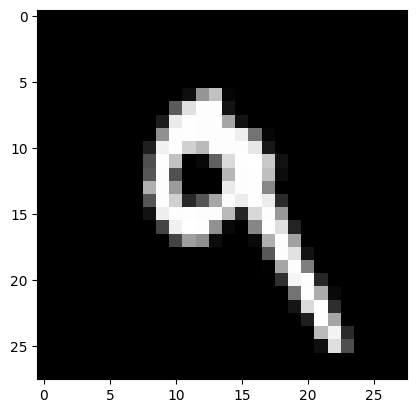

In [65]:
# 正常なデータ（摂動が加えられる前のデータ）。
target_index = 7
plt.imshow(x_test[target_index], cmap='gray')

# 正常データの推論
pred = classifier.predict(x_test[target_index][np.newaxis, ...])

# 推論結果の表示。
print('True label: "{}"\nPrediction: "{}"'.format([np.argmax(y_test[target_index])], [np.argmax(pred)]))

print('Done.')

True label: "[9]"
Prediction: "[8]"
Done.


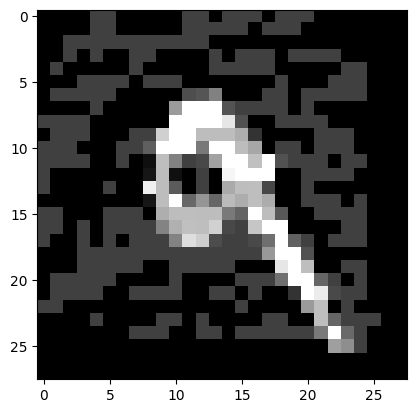

In [66]:
plt.imshow(X_test_adv[target_index], cmap='gray')

# 敵対的サンプルの推論。
pred_adv = classifier.predict(X_test_adv[target_index][np.newaxis, ...])

# 推論結果の表示。
print('True label: "{}"\nPrediction: "{}"'.format([np.argmax(y_test[target_index])], [np.argmax(pred_adv)]))

print('Done.')